In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import LSTM
from tensorflow.keras.layers import LSTM
#from keras.layers import CuDNNLSTM

from keras.layers import Dropout
#from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Embedding
import warnings
#from keras import backend as K
#from keras import backend as K
warnings.filterwarnings("ignore")
#K.tensorflow_backend._get_available_gpus()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pdf_file_path_train='/content/drive/MyDrive/Datasets/train.csv'
train_df=pd.read_csv(pdf_file_path_train, engine='python').set_index('id')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
pdf_file_path_test='/content/drive/MyDrive/Datasets/test.csv'
test_df=pd.read_csv(pdf_file_path_test, engine='python').set_index('id')
test_df.head()


,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [ ]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                            

In [ ]:
train_df.isnull().sum()

,0
target,0
comment_text,3
severe_toxicity,0
obscene,0
identity_attack,0
insult,0
threat,0
asian,1399744
atheist,1399744
bisexual,1399744


Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here. As it is only three Null values in 'comment_text' column, let's remove them first.

In [ ]:
train_df=train_df.dropna(subset=['comment_text'])


In [ ]:
train_df.isnull().sum()

,0
target,0
comment_text,0
severe_toxicity,0
obscene,0
identity_attack,0
insult,0
threat,0
asian,1399743
atheist,1399743
bisexual,1399743


In [ ]:
test_df.isnull().sum()

,0
comment_text,0


## EDA

### Target Feature

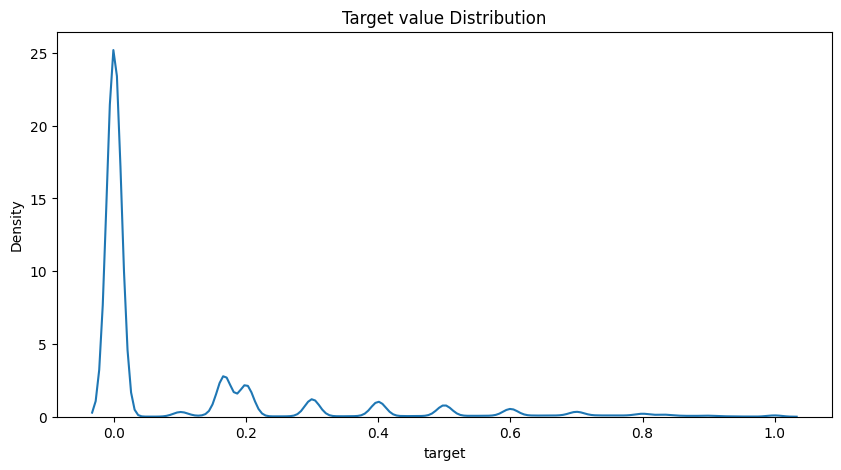

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Target value Distribution')
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='Target')

plt.show()

We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)

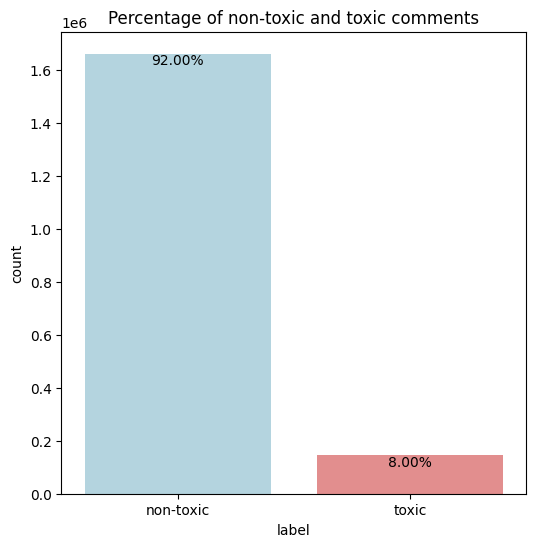

In [ ]:
import matplotlib.pyplot as plt
# Let's seperate toxic from non-toxic rating. If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.

# Classify comments as toxic or non-toxic
train_df['label'] = train_df['target'].apply(lambda x: 'non-toxic' if x < 0.5 else 'toxic')

# Count occurrences of each label
label_counts = train_df['label'].value_counts()

# Create the plot
plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=train_df, palette=['lightblue', 'lightcoral'])
plt.title('Percentage of non-toxic and toxic comments')
plt.ylabel('count')

# Calculate and display percentages
total = len(train_df)
for i, row in enumerate(label_counts):
    plt.text(i, row, f'{row/total:.2%}', ha='center', va='top')



plt.show()


**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

##  Toxicity Subtype Features:
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [ ]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit according to my needs
def plot_features_dist(features, title, data):
  plt.figure(figsize=(12, 6))
  plt.title(title)
  for feature in features:
    sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
  plt.xlabel('')
  plt.legend()
  plt.show()

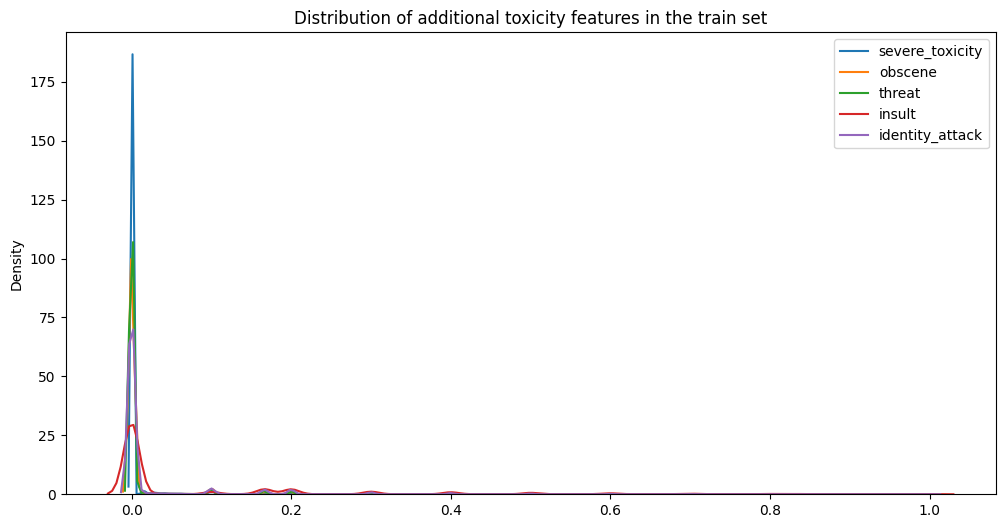

In [ ]:
features = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
plot_features_dist(features, "Distribution of additional toxicity features in the train set", train_df)

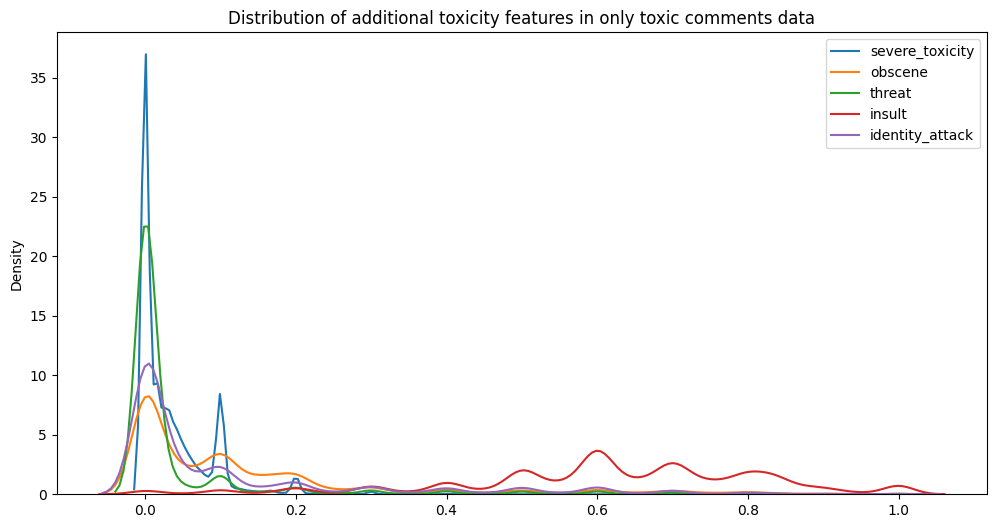

In [ ]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp=train_df[train_df['target']>0.5]
plot_features_dist(features, "Distribution of additional toxicity features in only toxic comments data", temp)

We see that for toxic comments data, there are more insulting comments as compared to obscene comments

In [ ]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]

    maxarg = np.argmax(np.array(row)) # Get the max value index.

    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

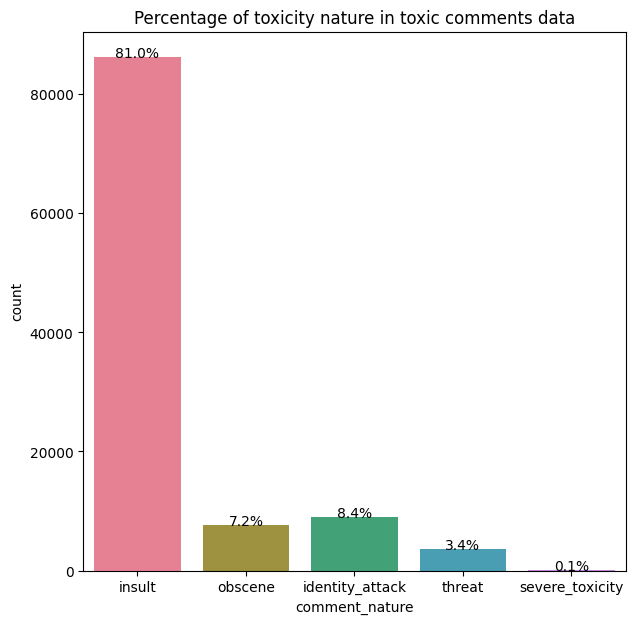

In [ ]:
# Apply the function to get the nature of each comment and store it in a new column named 'comment_nature'
temp['comment_nature'] = temp.apply(get_comment_nature, axis=1)

# Get the total number of comments
total = len(temp)

# Create a figure and an axes object
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Get unique comment natures
comment_natures = temp['comment_nature'].unique()

# Generate a colormap
cmap = mcolors.ListedColormap(sns.color_palette('husl', len(comment_natures)))

# Extract colors from the colormap
colors = cmap.colors

# Create a count plot using seaborn
cntplot = sns.countplot(x="comment_nature", data=temp, palette=colors)

# Set the title of the plot
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Calculate percentages and add them to the plot
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = height + 1  # Adjust the y-coordinate for better spacing
    ax.annotate(percentage, (x, y), ha='center', fontsize=10)

plt.show()

**Only 8% of our training data was classified as toxic. Of these toxic comments, insults accounted for the majority (81%), followed by identity attacks (8.37%), obscene content (7.20%), and threats (3.35%). A small percentage constituted severely toxic comments.**

## 3. Identity Attributes:
Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [ ]:
temp=train_df.dropna(axis=0, how='any')

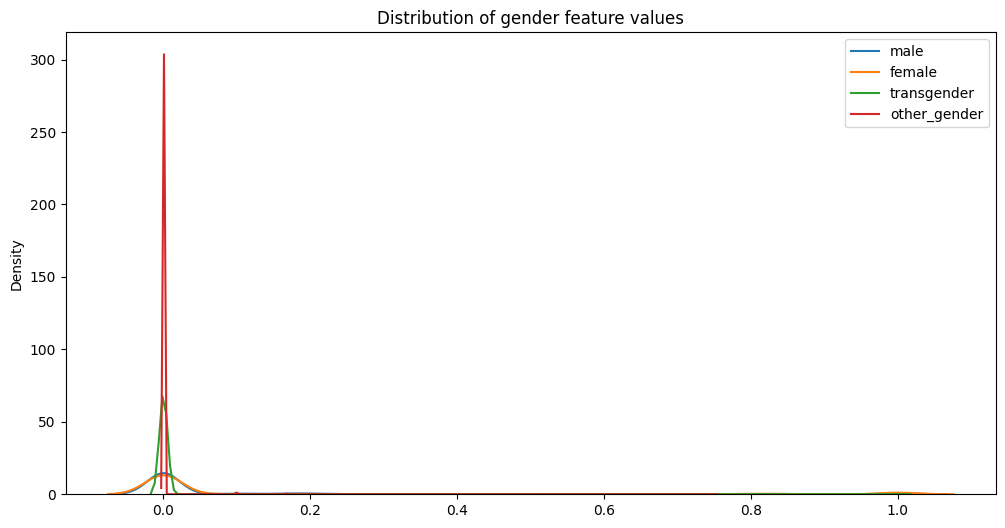

In [ ]:
features=['male', 'female', 'transgender', 'other_gender']
plot_features_dist(features, "Distribution of gender feature values", temp)

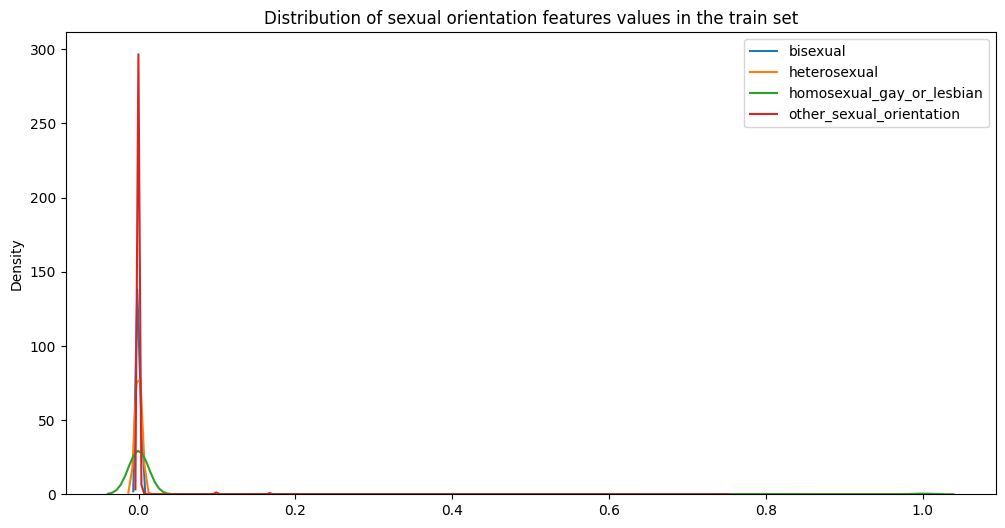

In [ ]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_dist(features, "Distribution of sexual orientation features values in the train set", temp)


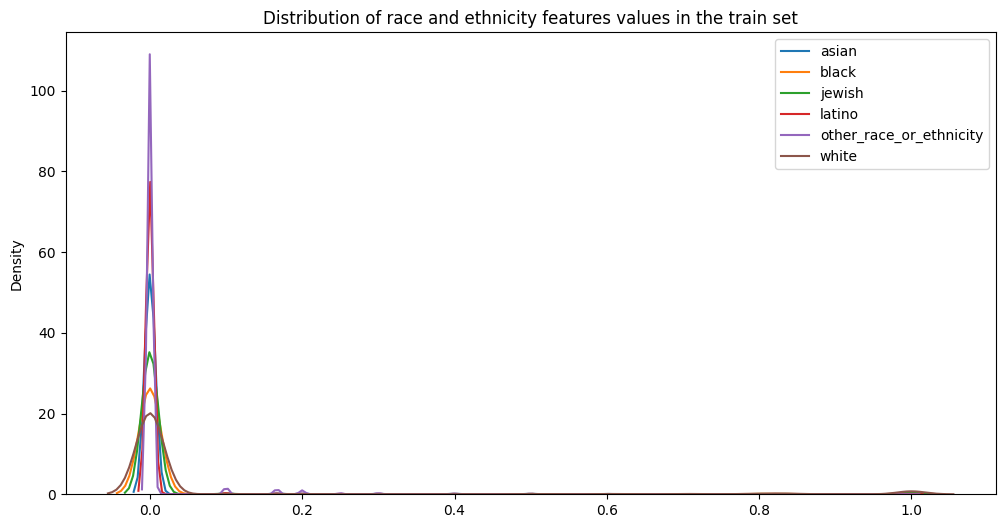

In [ ]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_dist(features, "Distribution of race and ethnicity features values in the train set", temp)

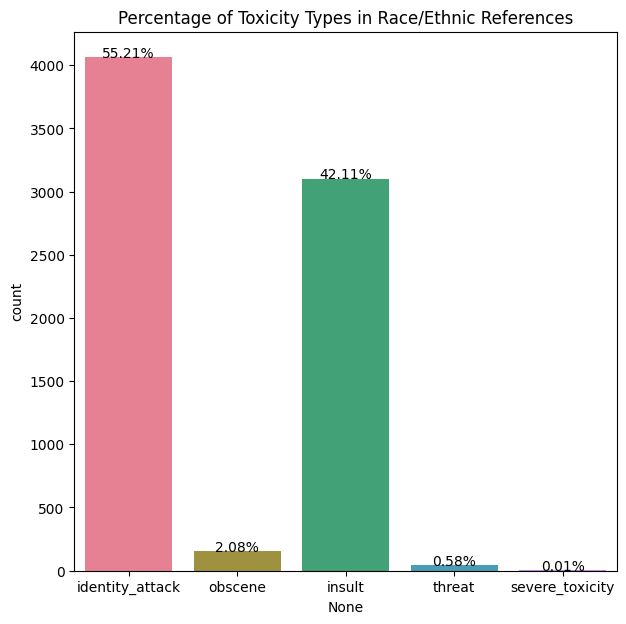

In [ ]:
# Filter the dataset for race/ethnicity references.
race_conditions = (
    (train_df['asian'] > 0.5) |
    (train_df['black'] > 0.5) |
    (train_df['jewish'] > 0.5) |
    (train_df['latino'] > 0.5) |
    (train_df['white'] > 0.5)
)

filtered_df = train_df[race_conditions]

# Further filter to include only toxic comments.
toxic_comments = filtered_df[filtered_df['target'] > 0.5]

# Apply function to determine the nature of each toxic comment.
comment_nature = toxic_comments.apply(get_comment_nature, axis=1)

# Set up the plot.
fig, ax = plt.subplots(figsize=(7,7))
total_comments = float(len(comment_nature))

# Create a horizontal count plot to visualize the types of toxicity.
count_plot = sns.countplot(x=comment_nature, ax=ax, palette=colors)
count_plot.set_title('Percentage of Toxicity Types in Race/Ethnic References')

# Annotate the plot with percentage labels.
for p in count_plot.patches:
    height = p.get_height()
    percentage = 100 * height / total_comments
    count_plot.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        '{:.2f}%'.format(percentage),
        ha='center'
    )

plt.show()


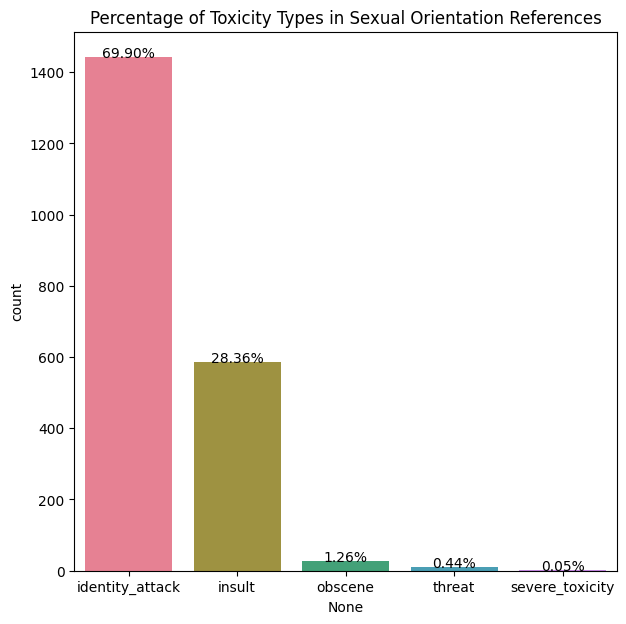

In [ ]:
# Filter the dataset for sexual orientation references.
orientation_conditions = (
    (train_df['bisexual'] > 0.5) |
    (train_df['heterosexual'] > 0.5) |
    (train_df['homosexual_gay_or_lesbian'] > 0.5) |
    (train_df['other_sexual_orientation'] > 0.5)
)

filtered_df = train_df[orientation_conditions]

# Further filter to include only toxic comments.
toxic_comments = filtered_df[filtered_df['target'] > 0.5]

# Apply function to determine the nature of each toxic comment.
comment_nature = toxic_comments.apply(get_comment_nature, axis=1)

# Set up the plot.
fig, ax = plt.subplots(figsize=(7,7))
total_comments = float(len(comment_nature))

# Get unique comment natures for the color palette.
unique_natures = comment_nature.unique()

# Generate a color palette.
palette = sns.color_palette('husl', len(unique_natures))

# Create a vertical count plot using seaborn.
count_plot = sns.countplot(x=comment_nature, palette=palette)
count_plot.set_title('Percentage of Toxicity Types in Sexual Orientation References')

# Annotate the plot with percentage labels.
for p in count_plot.patches:
    height = p.get_height()
    percentage = 100 * height / total_comments
    count_plot.text(
        p.get_x() + p.get_width() / 2.0,
        height + 1,
        '{:.2f}%'.format(percentage),
        ha='center'
    )

plt.show()


**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.**

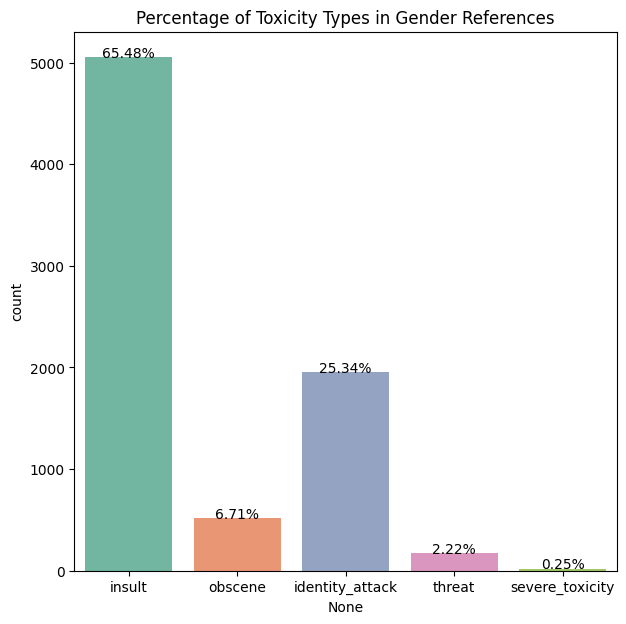

In [ ]:
# Filter the dataset for gender references.
gender_conditions = (
    (train_df['male'] > 0.5) |
    (train_df['female'] > 0.5) |
    (train_df['transgender'] > 0.5) |
    (train_df['other_gender'] > 0.5)
)

filtered_df = train_df[gender_conditions]

# Further filter to include only toxic comments.
toxic_comments = filtered_df[filtered_df['target'] > 0.5]

# Apply function to determine the nature of each toxic comment.
comment_nature = toxic_comments.apply(get_comment_nature, axis=1)

# Set up the plot.
fig, ax = plt.subplots(figsize=(7,7))
total_comments = float(len(comment_nature))

# Generate a color palette.
palette = sns.color_palette('Set2', len(comment_nature.unique()))

# Create a vertical count plot using seaborn.
count_plot = sns.countplot(x=comment_nature, palette=palette)
count_plot.set_title('Percentage of Toxicity Types in Gender References')

# Annotate the plot with percentage labels.
for p in count_plot.patches:
    height = p.get_height()
    percentage = 100 * height / total_comments
    count_plot.text(
        p.get_x() + p.get_width() / 2.0,
        height + 1,
        '{:.2f}%'.format(percentage),
        ha='center'
    )

plt.show()


**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

## Features generated by users feedback:
- funny
- sad
- wow
- likes
- disagree

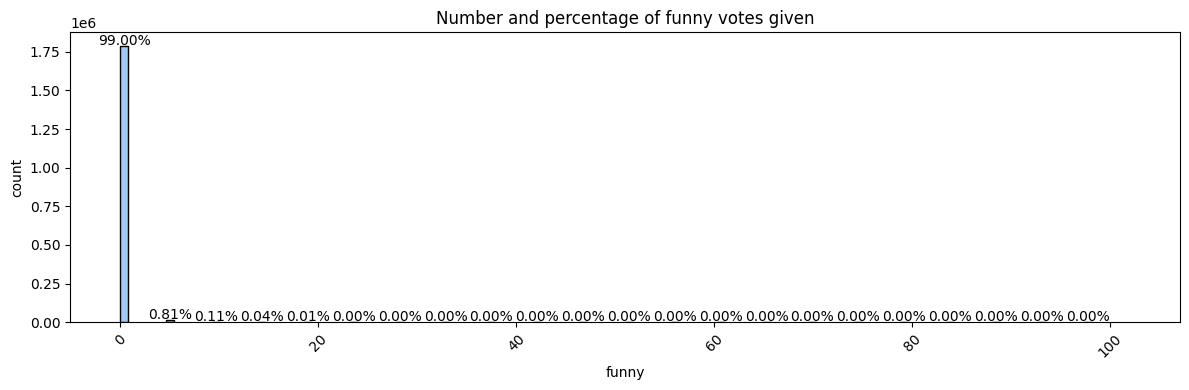

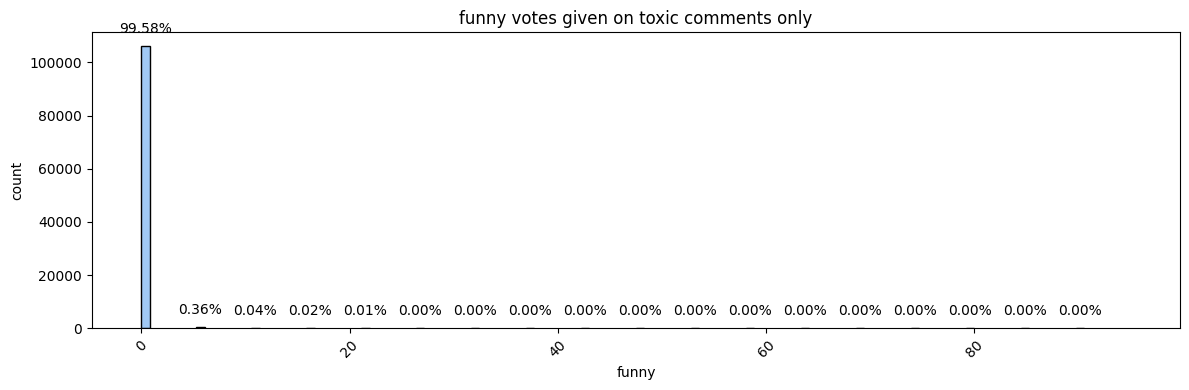

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # For color palette

def plot_count(feature, title, data, size=1, color_palette='pastel', figsize=(12, 4), bar_width=0.8):
  """
  Plots the count distribution of a feature with percentages on top of each bar and color.

  Args:
      feature: The name of the feature to plot.
      title: The title of the plot.
      data: The pandas DataFrame containing the data.
      size: The multiplier for the figure size (default: 1).
      color_palette: The seaborn color palette to use (default: 'pastel').
      figsize: The figure size in inches (default: (12, 4)).
      bar_width: The width of the bars (default: 0.8).
  """

  sns.set_palette(color_palette)  # Set the color palette
  plt.figure(figsize=figsize)  # Set figure size
  counts, bins, patches = plt.hist(data[feature], bins='auto', histtype='bar', edgecolor='k', width=bar_width)
  plt.xlabel(feature)
  plt.ylabel('count')
  plt.title(title)

  total = sum(counts)
  percentages = [100 * count / total for count in counts]

  for i, (p, count) in enumerate(zip(patches, percentages)):
    plt.text(p.get_x() + p.get_width() / 2., p.get_height() + 5000, '{:1.2f}%'.format(count), ha="center", color='black')  # Add color to text

  plt.xticks(rotation=45)  # Rotate x-axis labels for readability
  plt.tight_layout()  # Adjust spacing to prevent overlapping elements
  plt.show()

# Example usage
plot_count('funny', 'Number and percentage of funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)


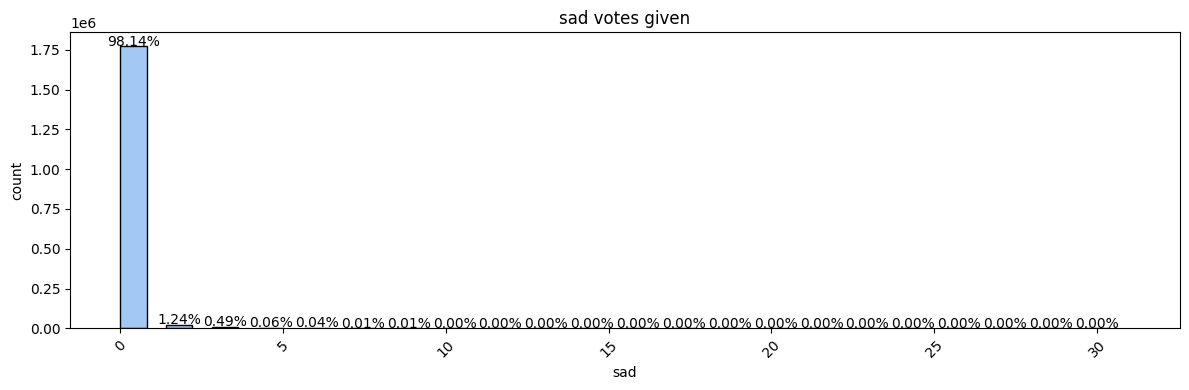

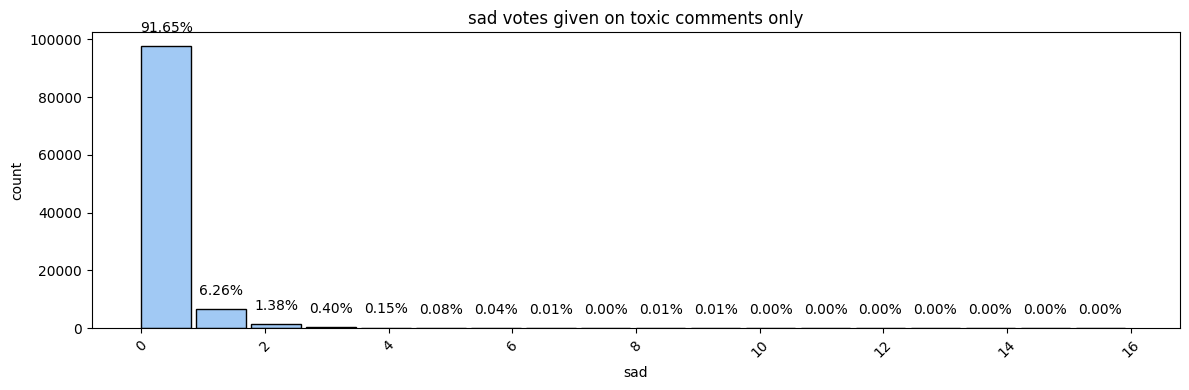

In [ ]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

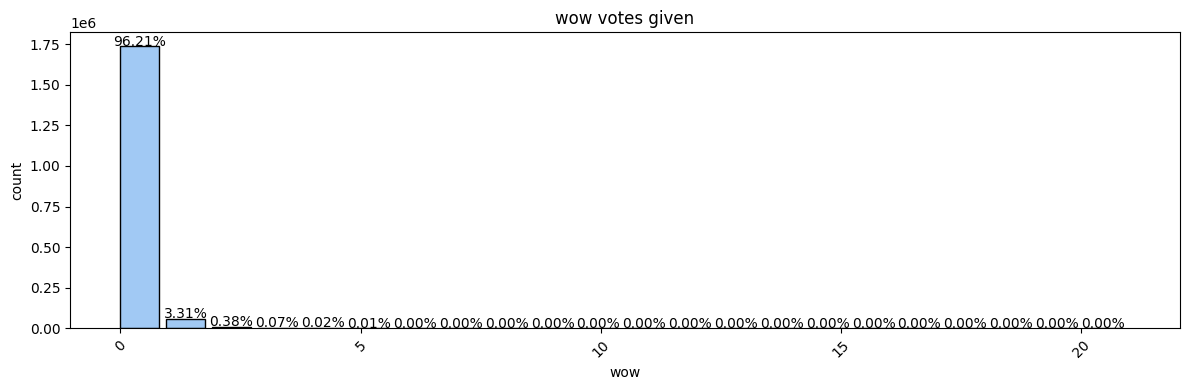

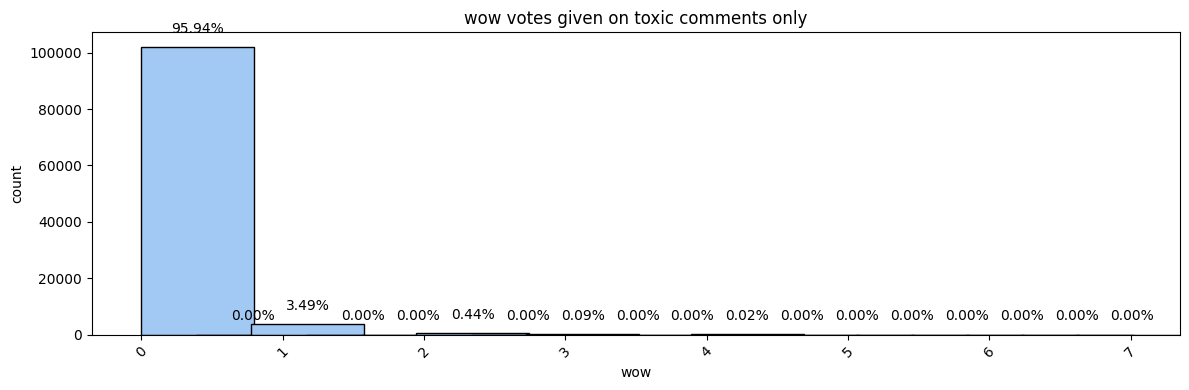

In [ ]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

## Comments_text Feature:

In [ ]:
from pickle import STOP
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title=None):
  wordcloud=WordCloud(
      background_color='white',
      stopwords=stpwrds,
      max_words=50,
      max_font_size=40,
      scale=5,
      random_state=1
  ).generate(str(data))

  fig=plt.figure(1, figsize=(10, 10))
  plt.axis('off')
  if title:
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)

  plt.imshow(wordcloud)
  plt.show()

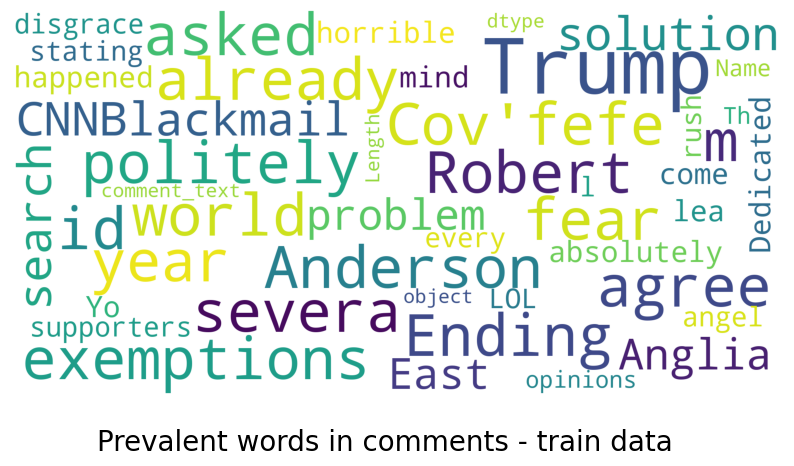

In [ ]:
show_wordcloud(train_df['comment_text'].sample(20000), title='Prevalent words in comments - train data')

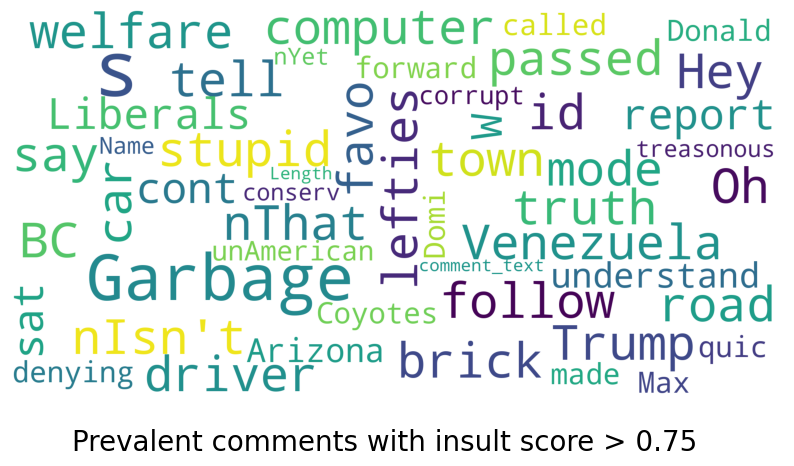

In [ ]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000),
               title = 'Prevalent comments with insult score > 0.75')

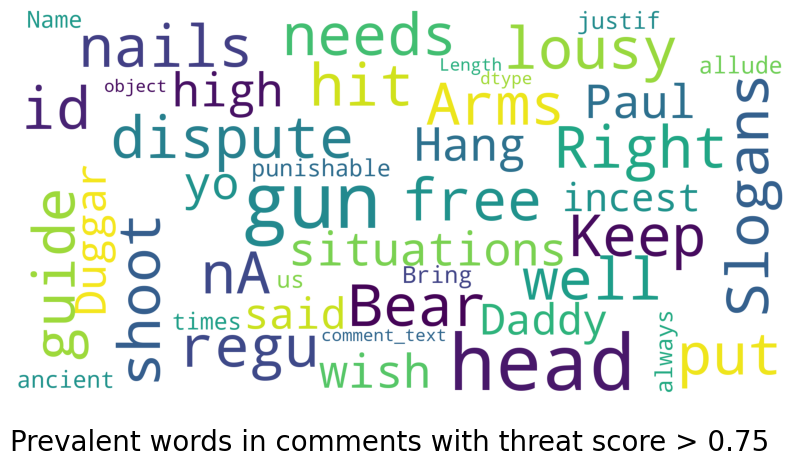

In [ ]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with threat score > 0.75')

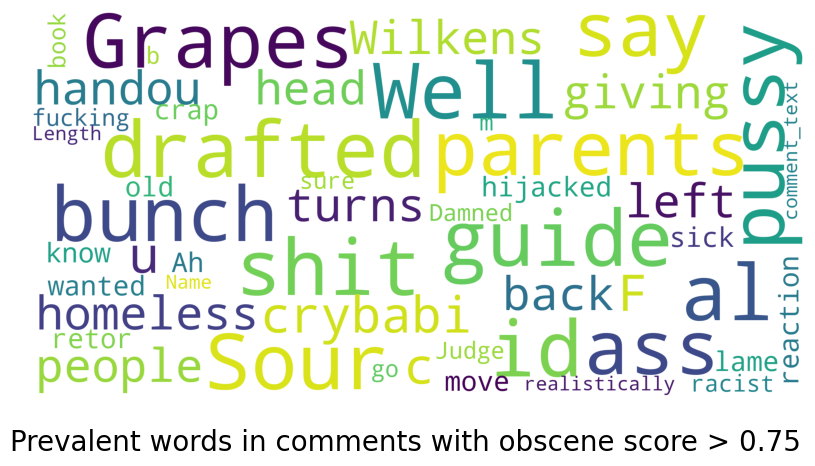

In [ ]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with obscene score > 0.75')

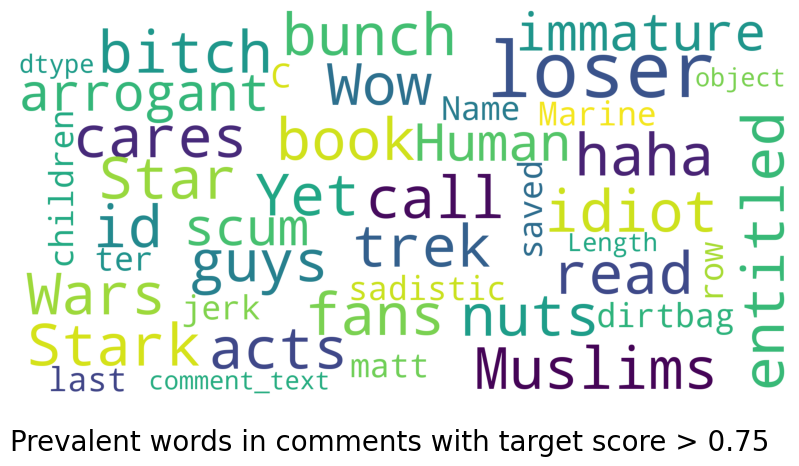

In [ ]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with target score > 0.75')

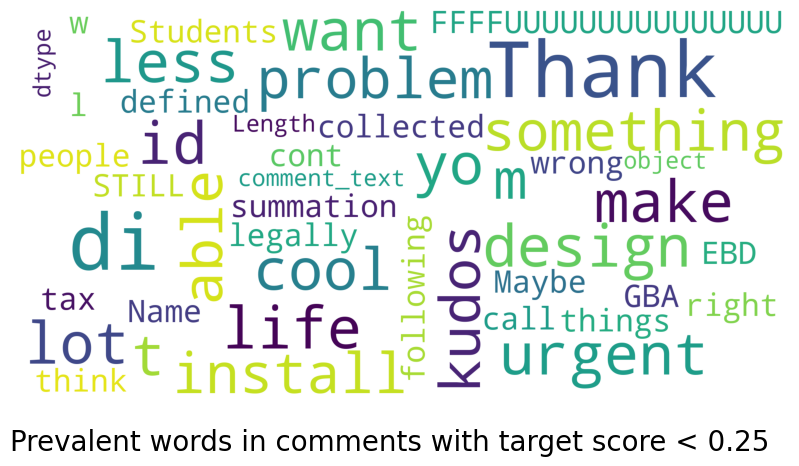

In [ ]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'],
               title = 'Prevalent words in comments with target score < 0.25')

## Preprocessing Text and Train-Test Split:

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stemmer = SnowballStemmer("english")
stop_words=set(stopwords.words('english'))
def preprocessing(text_string):
  text_string=text_string.lower() # Converts everything to lower case.
  text_string=re.sub('[^A-Za-z0-9]+', ' ', text_string) # Removes special characters and punctuations

  x=text_string.split()
  new_text=[]

  for word in x:
    if word not in stop_words:
      new_text.append(stemmer.stem(word))

  text_string = ' '.join(new_text)
  return text_string



In [ ]:
%%time
train_df['preprocessed_text']=train_df['comment_text'].apply(preprocessing)

CPU times: user 14min 1s, sys: 3.02 s, total: 14min 4s
Wall time: 14min 16s


In [ ]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,label,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0.0,0,4,non-toxic,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0.0,0,4,non-toxic,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0.0,0,4,non-toxic,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,0,0,0,0,0,0.0,0,4,non-toxic,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0.0,4,47,toxic,haha guy bunch loser


In [ ]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocessing)

CPU times: user 44.9 s, sys: 158 ms, total: 45.1 s
Wall time: 45.7 s


In [ ]:
feature=train_df[['preprocessed_text']]
output=train_df[['target']]
X_train, X_cv, y_train, y_cv=train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353653, 1)
(451218, 1)
(1353653, 1)
(451218, 1)


In [ ]:
X_train.head()

,preprocessed_text
id,
825693,bad huge chunk money wast govern bureaucraci v...
5024650,argu whatsoev fund return howev question much ...
5559019,cont question medicar necessari program elimin...
450969,noth common want respond comment attempt inter...
5368262,probabl grab pu safeti first


In [ ]:
X_cv.head()

,preprocessed_text
id,
6105659,ah gari hart beauti hear women complain use wo...
5653715,dagn use bathroom
665591,absolut right technolog chang better renew ene...
5561098,fact russia attempt influenc elect year multi ...
5760587,thank toni got wrong reit pay tax via share ho...


In [ ]:
y_train.head()

,target
id,
825693,0.000000
5024650,0.000000
5559019,0.000000
450969,0.000000
5368262,0.166667


In [ ]:
from tkinter.constants import X
X_test=test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [ ]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Models:

In [ ]:
# To load the csv files:
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

## 1. Bag of Words (BoW):

**Bag of Words (BoW)** is a simple technique used in natural language processing (NLP) to represent text data as numerical features for machine learning algorithms.

**How it works:**
- Tokenization: Text is broken down into individual words or tokens.
- Vocabulary Creation: All unique words from the text corpus are collected to form a vocabulary.
- Vectorization: Each document is represented as a numerical vector where each element corresponds to a word in the vocabulary. The value of each element indicates the frequency of that word in the document.

**Limitations:**
- Ignores word order and syntax: This can lead to loss of important information.
- Sensitive to stop words: Common words (like "the", "and", "of") might have high frequencies but little semantic value.
- High dimensionality: Large vocabularies can result in high-dimensional feature vectors, which can impact performance.

**Improvements:**
- TF-IDF: Weighs words based on their importance within a document and across the corpus.
- N-grams: Considers sequences of words (bigrams, trigrams) to capture some word order information.
While BoW is a basic technique, it serves as a foundation for more advanced NLP methods and is still widely used in various applications due to its simplicity and efficiency.

In [ ]:
cnt_vec=CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train=cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv=cnt_vec.transform(X_cv['preprocessed_text'])
bow_test=cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353653, 30000)
(451218, 30000)
(97320, 30000)


## SGDRegressor:
### 1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")

        model = SGDRegressor(alpha=a, penalty=p)
        model.fit(bow_train, y_train) # Train

        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.02279073200127839
Mean Squared Error on cv set:  0.02295893235178238
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.022190288153544895
Mean Squared Error on cv set:  0.022691802544823895
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.024461856256579973
Mean Squared Error on cv set:  0.024548788846604164
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.022275910118979655
Mean Squared Error on cv set:  0.022753874917479874
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03139681537318133
Mean Squared Error on cv set:  0.03137586785414162
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.023239278188028737
Mean Squared Error on cv set:  0.023538931770666023
***************************************

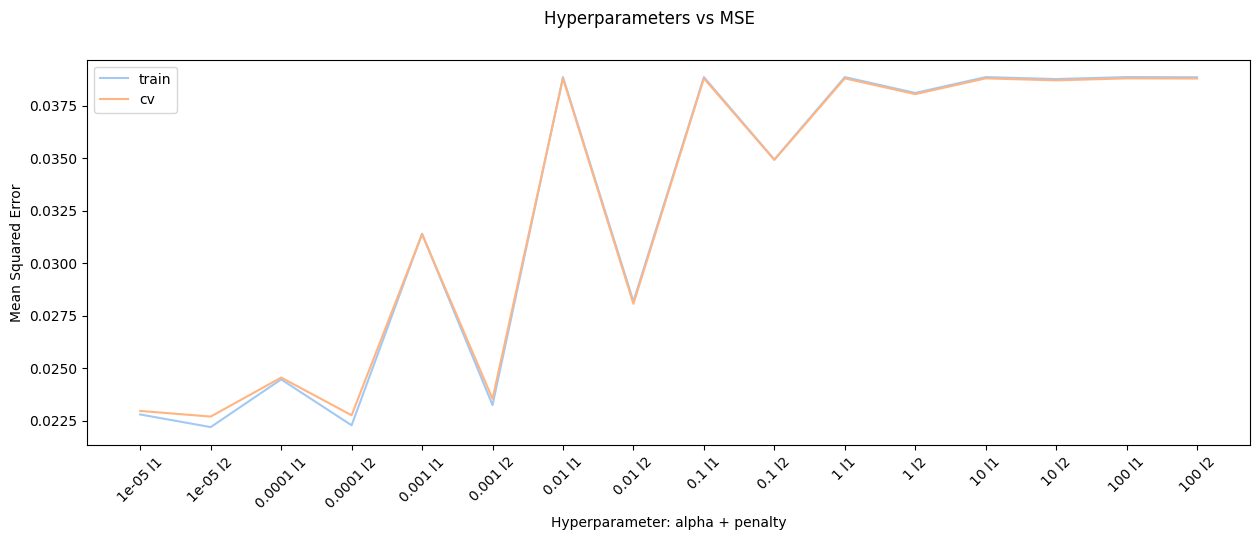

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.417869
stupid,0.336683
moron,0.322743
pathet,0.295550
crap,0.285066
shit,0.276147
jerk,0.271826
hypocrit,0.270679
ass,0.263686
scum,0.263603


In [ ]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
stupid stupid,-0.137712
knee jerk,-0.085962
fool peopl,-0.060703
black white,-0.060022
winner loser,-0.050662
dumb dumb,-0.049788
ignor fact,-0.048838
liar liar,-0.043481
black market,-0.041773
give damn,-0.040622


## Decision Trees:
### 1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")

        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train

        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03310691452559487
Mean Squared Error on cv set:  0.033108638863473115
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03310691452559485
Mean Squared Error on cv set:  0.03310863886347311
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03310882929109805
Mean Squared Error on cv set:  0.03311109238190598
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03202729317371084
Mean Squared Error on cv set:  0.032043175315339706
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032030108464491856
Mean Squared Error on cv set:  0.032042262625062455
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tr

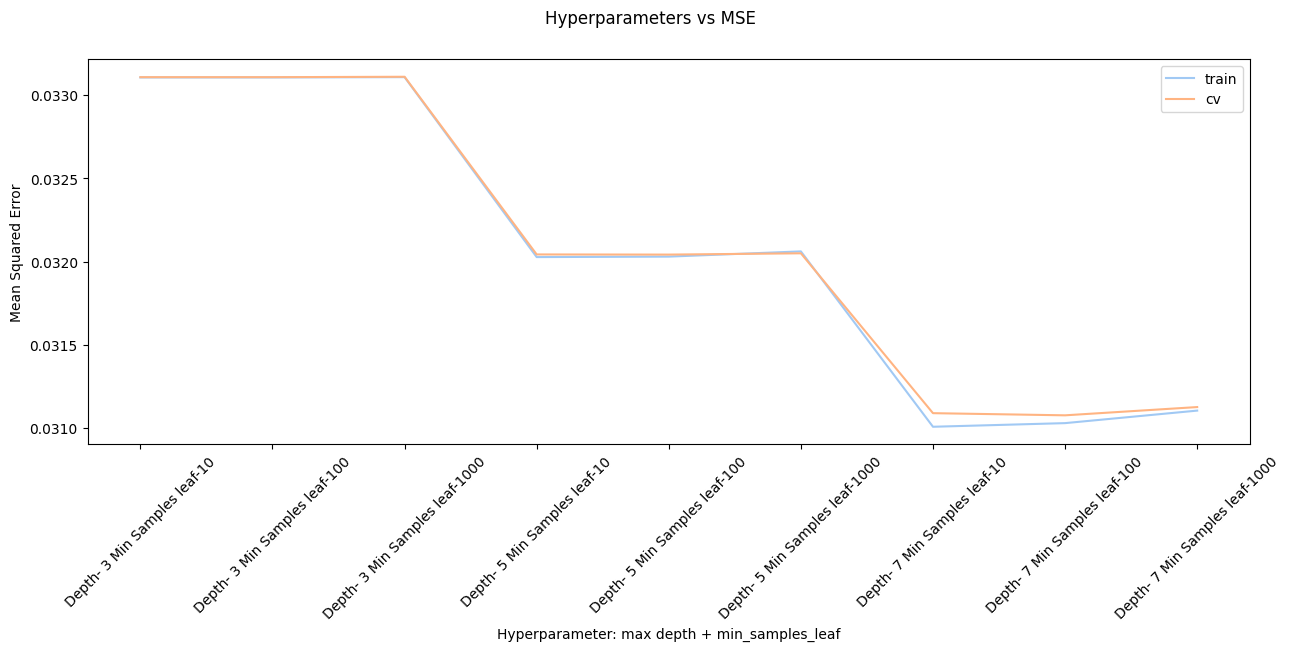

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.395863
idiot,0.262160
pathet,0.071017
fool,0.067788
moron,0.062849
white,0.059474
hypocrit,0.056573
racist,0.005437
would,0.004019
one,0.003638


## Term Frequency - Inverse Document Frequency (TFIDF) :

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353653, 30000)
(451218, 30000)
(97320, 30000)


 ## SGDRegressor:
### 1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")

        model = SGDRegressor(alpha=a, penalty=p)
        model.fit(tfidf_train, y_train) # Train

        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.0252622246472539
Mean Squared Error on cv set:  0.025282034543075826
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.0238986303198076
Mean Squared Error on cv set:  0.02398294589744715
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.02973515892956246
Mean Squared Error on cv set:  0.029701053377922632
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.02501539406852479
Mean Squared Error on cv set:  0.02508290960650261
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03832708695889898
Mean Squared Error on cv set:  0.03825859882321971
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.030062196511099305
Mean Squared Error on cv set:  0.030067794688443675
*********************************************

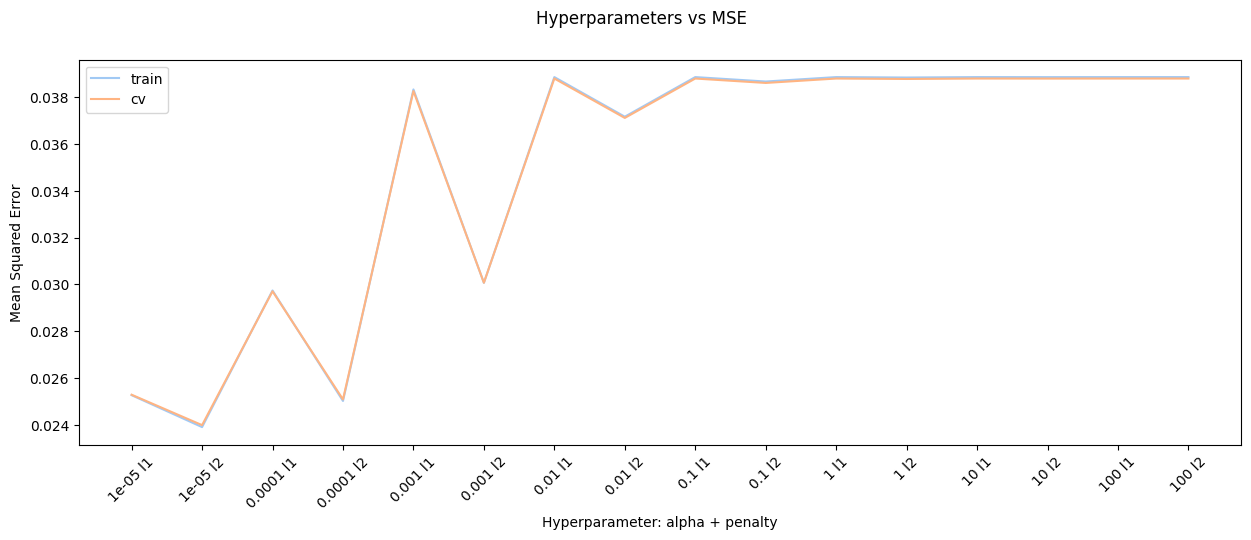

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

### Feature Importance:

In [ ]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.564233
idiot,1.262443
fool,0.662234
ignor,0.612360
dumb,0.598923
pathet,0.597162
moron,0.575045
ridicul,0.568096
loser,0.551416
hypocrit,0.519578


In [ ]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.093548
interest,-0.085590
stori,-0.076577
agre,-0.076396
great,-0.073152
may,-0.072567
new,-0.069323
good,-0.068278
point,-0.067729
differ,-0.067522


## Decision Trees:
### 1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")

        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train

        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03290534982790964
Mean Squared Error on cv set:  0.032895231461803544
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03290534982790964
Mean Squared Error on cv set:  0.032895231461803544
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03290534982790963
Mean Squared Error on cv set:  0.03289523146180354
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.031768305421136706
Mean Squared Error on cv set:  0.03176153217984729
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.031769435109051655
Mean Squared Error on cv set:  0.03175887223961078
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tr

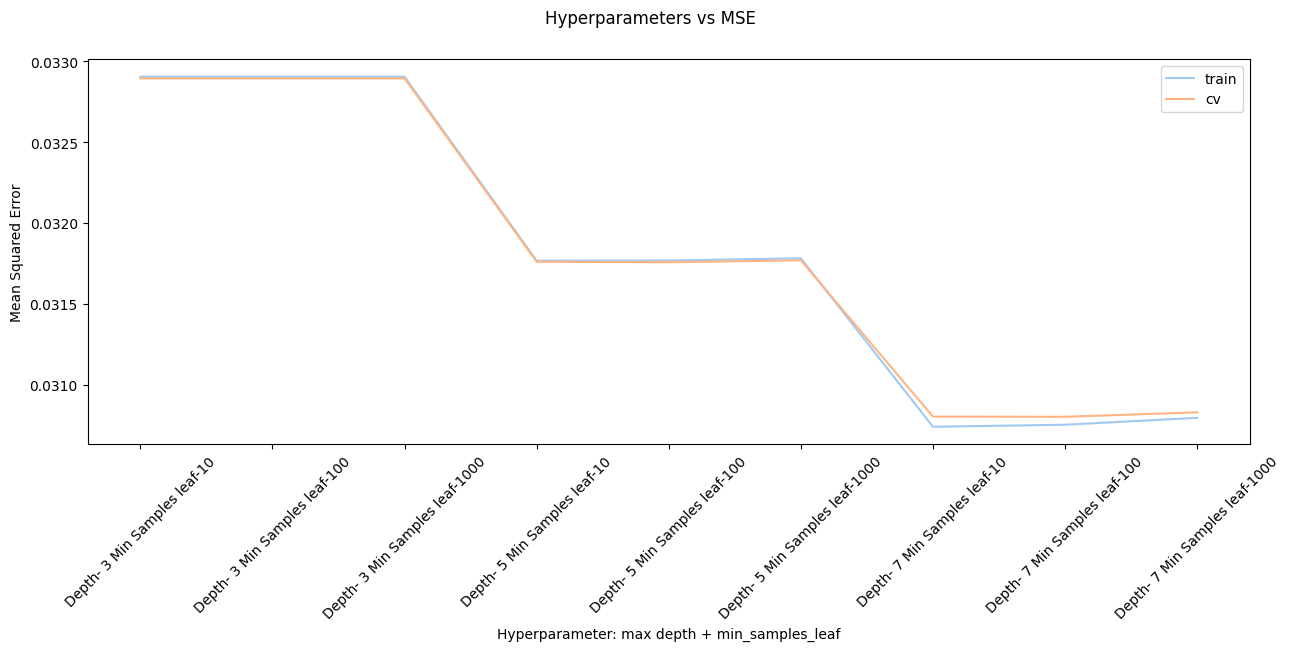

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()